## Dynamic Decoupling
Dynamic Decoupling could be made very specific for the hardware, but it assumes we know the interactions of the circuit with the environment. We can optimize the circuit by learning the parameters from the circuit, calcuting the cost function.

- Applying control pulses during qubit idle periods has low overhead
- Single qubit sequences such as CPMG, Universally robust DD, Eulerian DD do not extend to multip-qubits 
- Staggered single-qubit DD sequences have been studied for crosstalk suppression, but limited since multi-qubit gates are far more complex
- Empirically learned DD tailored to a given quantum device and task at hand using classical optimization works really well. So applying DD requires applying a $\bold{pre-programmed\ sequence}$ of pulses during idle periods in any quantum computation. 

Dynamical decoupling works by adding pulse sequences (known as dynamical decoupling sequences) to idle qubits to flip them around the Bloch sphere, which cancels the effect of noise channels, thereby suppressing decoherence. 

X and Y gates are often implemented as finite width control pulses on
quantum hardware, while Z is implemented as a virtual state rotation, leading to distinct experimental behavior of theoretically equivalent DD sequences. This breaks the equivalence of the gates which comprise the equivalence class. Similarly, Identity serves to control the gap lengths between pulses. 

### Step 1
Build the circuit, lets do the Bell basis


In [103]:
# Import necessary modules for this notebook
import qiskit
import time
import math
import numpy as np
from math import *

#design
from qiskit import *
from qiskit.circuit import *
from qiskit.quantum_info import *
from qiskit.visualization import *
from qiskit.circuit.library import *

from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import *
from qiskit.transpiler.passes import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import *
print(qiskit.__version__)

1.4.2


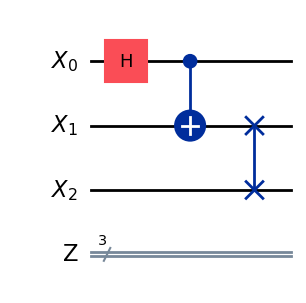

In [145]:
m = 3
n = 0
control = QuantumRegister(m, "X")
target = QuantumRegister(n, "Y")
output = ClassicalRegister(m, "Z")

qc_orig = QuantumCircuit(control, target, output)
qc_orig.h(0)
qc_orig.cx(0,1)
qc_orig.swap(1,2)

#qc.measure_all()
display(qc_orig.draw(output = "mpl"))


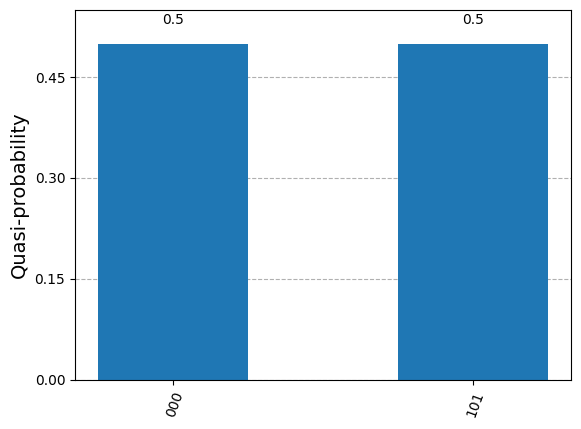

In [116]:
ideal_distribution = Statevector.from_instruction(qc_orig).probabilities_dict()

plot_histogram(ideal_distribution)

### Step 2 
Transpile the circuit,
1. Use build in Generate pass manager + Qiskit's DD 
2. Build a custom pass using the Learning Dynamic Decoupling 

### Step 3 
Execute the circuit, 
1. try Qiskit's Dynamic Decoupling sequences in this step : PadDynamicDecoupling. dynamical decoupling pulses need to be added after the circuit has been transpiled and scheduled.
2. Using our pass manager, execute using Qiskit's primitives 

### Step 4 
Post processing the circuit, compare with CPMG and XYXY

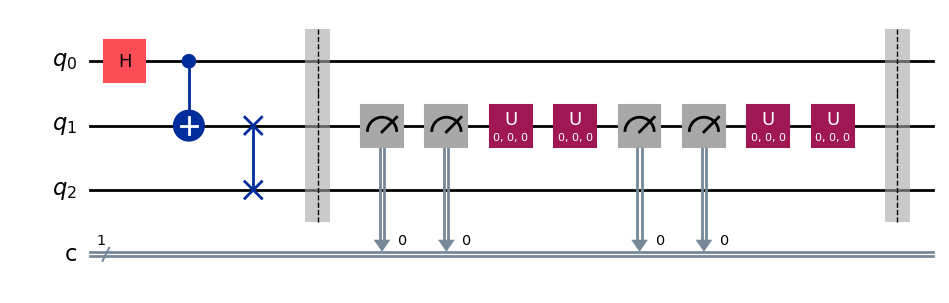

In [148]:
# Noisy circuit simulation
# local measurements, r times 
qbits = QuantumRegister(3, "q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qbits, cbits)
qc.h(0)
qc.cx(0, 1)
qc.swap(1, 2)

def single_rotations(theta, phi, lam, N):
    ug = UGate(theta, phi, lam, 1)
    return ug

# function for applyign DD sequences
#qc.u(0, 0, 0, 1)
#print(single_rotations(0, 0, 0, 1))
qc.barrier()

def pulse_sequence(N, r, theta, phi, lam):
    #R_x = u(theta, phi, lam, 1)
    [qc.measure(1, cbits) for _ in range(N//2)]
    [qc.u(theta, phi, lam, 1) for _ in range(r) ]
    [qc.measure(1, cbits) for _ in range(N//2)]
    [qc.u(-theta, -phi, -lam, 1) for _ in range(r) ]

#qc.to_gate(pulse_sequence(4, 2, 0, 0, 0))    
 
pulse_sequence(4, 2, 0, 0, 0)
qc.barrier()
#qc.measure_all()

display(qc.draw("mpl"))

In [ ]:
# Circuit Optimization using a Simulator for an ibm backend
service = QiskitRuntimeService(channel="ibm_quantum")
real_backend = service.backend("ibm_brisbane")
sim_backend = AerSimulator.from_backend(real_backend,seed_simulator=42)

sim_pm = generate_preset_pass_manager(
        backend=sim_backend,
        optimization_level=3, 
        layout_method = "sabre", 
        seed_transpiler = 42
)

### Dynamic Decoupling using CPMG Pulse sequences, i.e. even no. of pauli X pulses

In [149]:

target = real_backend.target

#durations for each gate, error
durations = target.durations()

# from configuration , open_pulse
coupling_map = real_backend.configuration().coupling_map
basis_gates = real_backend.configuration().basis_gates
n_qubits = real_backend.configuration().n_qubits
dt = real_backend.configuration().dt
timing_constraints = real_backend.configuration().timing_constraints

# properties : T1, T2, Readout, gate errors, 

durations_gen = InstructionDurations(
    [("h", None, 40), ("cx", None, 200), ("reset", None, 10), 
     ("x", None, 40), ("u", None, 60), ("swap", None, 400), 
     ("measure", None, 1000), ("measure", 1, 200)],
     dt = 1e-7
)

#schedule_map = real_backend.defaults().instruction_schedule_map
# Uhrig sequence on qubit 0
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))

# this step we're just modifying the scheduling stage of the transpilation step 
pm = PassManager([ALAPScheduleAnalysis(durations_gen), # identifies the idel durations pulse_alignment= timing_constraints, 
                  PadDynamicalDecoupling(durations_gen, dd_sequence, spacing = spacing)]) 
circ_dd = pm.run(qc)


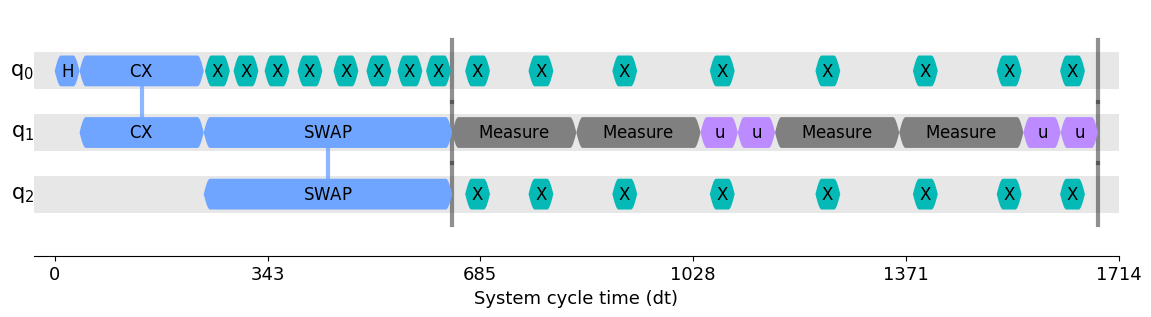

In [150]:
timeline_drawer(circ_dd, target=target)

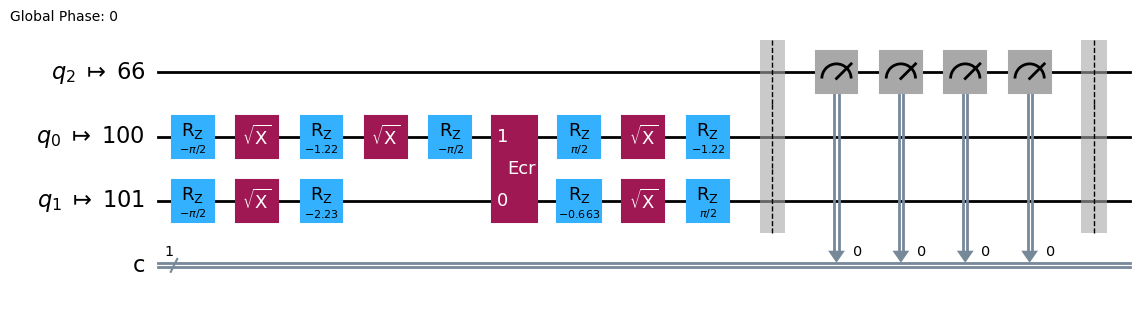

In [138]:
isa_circuit = sim_pm.run(qc)

display(isa_circuit.draw("mpl", idle_wires= False))
#timeline_drawer(isa_circuit, target=target)

#### Defining the LDD Sequence 

In [112]:
from qiskit import pulse 
from qiskit.pulse  import *
from qiskit_ibm_runtime.fake_provider import *

def LDD_sequence(tau, theta, phi, lam, dt, qbit, r):
    duration = int(160)
    amp = 0.2
    sigma = duration/10

    with pulse.build(name = "LDD") as ldd_seq:
        d0 = pulse.DriveChannel(qbit)
        for i in range(r):
            pulse.delay(tau, d0)
            pulse.shift_phase(theta, d0) #z
            pulse.play(pulse.Gaussian(duration, amp, sigma), d0) #y
            pulse.shift_phase(lam, d0) #z
            pulse.delay(tau, d0)
            pulse.shift_phase(-theta, d0) #z
            pulse.play(pulse.Gaussian(duration, amp, sigma), d0) #y
            pulse.shift_phase(-lam, d0) #z
        #pulse.delay(tau, d0)
        #ldd_seq.draw()

    return ldd_seq


/var/folders/_l/lts7v2js3bbfkykccz2230q80000gn/T/ipykernel_45635/4209927461.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name = "LDD") as ldd_seq:
/var/folders/_l/lts7v2js3bbfkykccz2230q80000gn/T/ipykernel_45635/4209927461.py:11: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  d0 = pulse.DriveChannel(qbit)
/var/folders/_l/lts7v2js3bbfkykccz2230q80000gn/T/ipykernel_45635/4209927461.py:13: DeprecationWarning: The function ``qiskit.pulse.builder.delay()`` is deprecated as of Qiskit 1.3. 

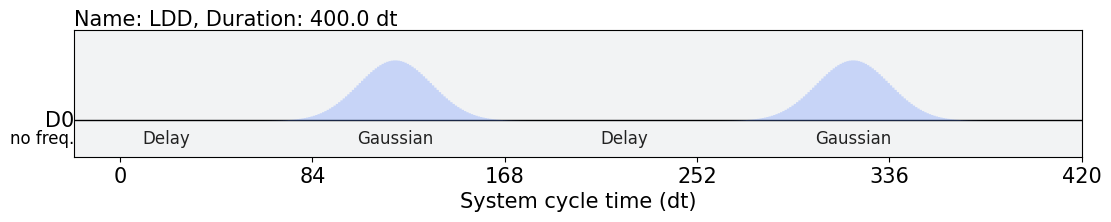

In [113]:
schedule = LDD_sequence(40, 0, 0, 0, 1e-9, 0, 1)
schedule.draw()

/var/folders/_l/lts7v2js3bbfkykccz2230q80000gn/T/ipykernel_45635/3976650255.py:12: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` will have no alternative in Qiskit.
  qc_orig.add_calibration(custom_gate, [0], schedule)


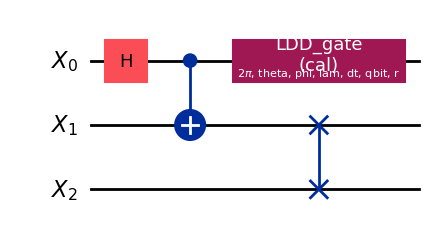

In [153]:
### Convert it to a gate 
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')
qbit = Parameter('qbit')
r = Parameter('r')
dt = Parameter('dt')

#qc.measure_all()
custom_gate = Gate(name = "LDD_gate", num_qubits= 1, params=[tau, theta, phi, lam, dt, qbit, r])
qc_orig.append(custom_gate, [0])
qc_orig.add_calibration(custom_gate, [0], schedule)

display(qc_orig.draw("mpl", idle_wires= False))


Now we're trying to optimize the circuit using the same simulated backend, but with a different pass manager to identify the idel times as well, where the LDD pulses should be applied

In [ ]:

isa_circuit2 = transpile(qc_orig, backend=sim_backend, scheduling_method='alap', optimization_level=3)

from qiskit.pulse.channels import DriveChannel

d0 = DriveChannel(0)
insts = schedule.filter(channels=[d0]).instructions

# Find idle periods on DriveChannel(0)
idle_slots = []
current_time = 0

for (t, inst) in insts:
    if t > current_time:
        idle_slots.append((current_time, t))  # An idle gap
    current_time = max(current_time, t + inst.duration)

print(idle_slots)


TranspilerError: "HighLevelSynthesis was unable to synthesize Instruction(name='LDD_gate', num_qubits=1, num_clbits=0, params=[6.283185307179586, Parameter(theta), Parameter(phi), Parameter(lam), Parameter(dt), Parameter(qbit), Parameter(r)])."

The code fails, since the Transpiler fails to synthesize the instruction, because the High Level Synethesis in Qiskit only works with well defined values of parameters, not free parameters, which is yet to be implemented. 